In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm

In [2]:
#TODO: define all your input here
experiment_dir = 'outputs/mirror-mouse/hand=100_pseudo=1000'
dataset = "mirror-mouse"
likelihood_threshold = 4
std_threshold = 2000

In [3]:

data_dir = '/teamspace/studios/this_studio'
file_paths = [
    os.path.join(data_dir, experiment_dir,'networks', f'rng{i}', 'predictions_new.csv')
    for i in range(4)
]
review_dir = os.path.join(data_dir, experiment_dir, 'review_frames')
os.makedirs(review_dir, exist_ok=True)

output_file_name = 'frames_quality_control.csv'
output_file_path = os.path.join(review_dir, output_file_name)



In [4]:
def process_and_merge_csv_files(file_paths_and_identifiers, output_file_path):
    merged_data = None

    for file_path in file_paths:

        # Extract the identifier from the file path
        rng_identifier = os.path.basename(os.path.dirname(file_path))
        data = pd.read_csv(file_path)
        data_transformed = []

        # Extract body part names from the first row
        # taking every third column starting from the second
        body_parts = data.iloc[0, 1::3].tolist()

        # starting from the third row (index 2)
        for i in range(2, len(data)):
            
            # Get the image path from the first column of the current row
            image_path = data.iloc[i, 0]
            for j, part in enumerate(body_parts):

                # index for the x-coordinate - every third column starting from the second
                x_index = 1 + j*3
                # index for the y-coordinate - every third column starting from the third
                y_index = 2 + j*3
                # index for likelihood 
                likelihood_index = 3 + j*3

                if all(index < len(data.columns) for index in [x_index, y_index, likelihood_index]):
                    x, y, likelihood = data.iloc[i, [x_index, y_index, likelihood_index]]
                    data_transformed.append([image_path, part, x, y, likelihood])

        transformed_df = pd.DataFrame(data_transformed, columns=["image_path", "body_part", f"x_{rng_identifier}", f"y_{rng_identifier}", f"likelihood_{rng_identifier}"])
        
        if merged_data is None:
            merged_data = transformed_df
        else:
            merged_data = pd.merge(merged_data, transformed_df, on=["image_path", "body_part"])

    # Calculate ensemble mean and variance for x and y coordinates
    merged_data['ensemble_mean_x'] = merged_data[
        [f'x_rng{i}' for i in range(4)]
    ].astype(float).mean(axis=1)

    merged_data['ensemble_mean_y'] = merged_data[
        [f'y_rng{i}' for i in range(4)]
    ].astype(float).mean(axis=1)

    merged_data['ensemble_median_x'] = merged_data[
        [f'x_rng{i}' for i in range(4)]
    ].astype(float).median(axis=1)

    merged_data['ensemble_median_y'] = merged_data[
        [f'y_rng{i}' for i in range(4)]
    ].astype(float).median(axis=1)

    merged_data['ensemble_variance_x'] = merged_data[
        [f'x_rng{i}' for i in range(4)]
    ].astype(float).var(axis=1)

    merged_data['ensemble_variance_y'] = merged_data[
        [f'y_rng{i}' for i in range(4)]
    ].astype(float).var(axis=1)

    merged_data['ensemble_variance'] = merged_data['ensemble_variance_x'] + merged_data['ensemble_variance_y']

    merged_data['ensemble_std'] = np.sqrt(merged_data['ensemble_variance'])

    # Count likelihoods above 0.9
    merged_data['num_likelihood_above_0.9'] = merged_data[
        [f'likelihood_rng{i}' for i in range(4)]
    ].astype(float).gt(0.9).sum(axis=1)


    # Create custom bins for ensemble standard deviation
    std_bins = [0, 5, 10, 15, 20, float('inf')]
    std_labels = ['0-5', '5-10', '10-15', '15-20', '20+']

    merged_data['ensemble_std_bin'] = pd.cut(
        merged_data['ensemble_std'], bins=std_bins, labels=std_labels, include_lowest=True
    )
    
    # Apply logarithmic scale to ensemble variance
    merged_data['ensemble_variance_log'] = np.log1p(merged_data['ensemble_variance'])

    # Create bins for logarithmic ensemble variance
    merged_data['ensemble_variance_log_bin'] = pd.cut(
        merged_data['ensemble_variance_log'], bins=10, labels=False
    )

    log_bins = pd.cut(merged_data['ensemble_variance_log'], bins=10)
    merged_data['ensemble_variance_log_bin_label'] = log_bins.apply(lambda x: f'{x.left:.1f}-{x.right:.1f}')

    ensemble_variance_bins_labels = pd.cut(merged_data['ensemble_variance'], bins=10)
    merged_data['ensemble_variance_bin_label'] = ensemble_variance_bins_labels.apply(lambda x: f'{x.left:.1f}-{x.right:.1f}')
    
    # Save the merged dataframe to a CSV file
    merged_data.to_csv(output_file_path, index=False)
    print(f"Concatenated data saved to {output_file_path}")

    return merged_data

quality_control_df = process_and_merge_csv_files(file_paths, output_file_path)



FileNotFoundError: [Errno 2] No such file or directory: '/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng1/predictions_new.csv'

In [ ]:
#Read frames_quality_control.csv
try:
    quality_control_df = pd.read_csv(output_file_path)
except FileNotFoundError:
    print(f"Error: The file {output_file_path} was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file {output_file_path} is empty.")
except Exception as e:
    print(f"An error occurred while reading the file: {str(e)}")

In [ ]:
# # def create_heatmaps(data, output_dir):
# #     def plot_heatmap(data, title, xlabel, ax):
# #         sns.heatmap(data[::-1], annot=True, fmt="d", cmap="Blues", ax=ax)
# #         ax.set_title(title)
# #         ax.set_xlabel(xlabel)
# #         ax.set_ylabel('Number of Highly Confident Networks')
# #         ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# #     # Define the correct order of bins
# #     bin_order = ['0-5', '5-10', '10-15', '15-20', '20+']

# #     heatmap_data_std = data.pivot_table(
# #         index='num_likelihood_above_0.9', 
# #         columns='ensemble_std_bin', 
# #         aggfunc='size', 
# #         fill_value=0
# #     )

# #     # Reorder the columns based on the correct bin order
# #     heatmap_data_std = heatmap_data_std.reindex(columns=bin_order)

# #     fig, ax = plt.subplots(figsize=(12, 8))

# #     plot_heatmap(heatmap_data_std, 'Heatmap of Ensemble Standard Deviation Bins\nvs Number of Highly Confident Networks', 'Ensemble Standard Deviation Bin', ax)

# #     plt.tight_layout()
    
# #     output_image_path = os.path.join(output_dir, 'ensemble_std_heatmap.png')
# #     fig.savefig(output_image_path, dpi=300, bbox_inches='tight')
# #     plt.close(fig) 
# #     print(f"Heatmap image saved to {output_image_path}")

# # create_heatmaps(quality_control_df, review_dir)

# def create_heatmaps(data, output_dir):
#     def plot_heatmap(data, title, xlabel, ax):
#         sns.heatmap(data[::-1], annot=True, fmt="d", cmap="Blues", ax=ax)
#         ax.set_title(title)
#         ax.set_xlabel(xlabel)
#         ax.set_ylabel('Number of Highly Confident Networks')
#         ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

#     # Define the correct order of bins
#     bin_order = ['0-5', '5-10', '10-15', '15-20', '20+']

#     heatmap_data_std = data.pivot_table(
#         index='num_likelihood_above_0.9', 
#         columns='ensemble_std_bin', 
#         aggfunc='size', 
#         fill_value=0
#     )

#     # Reorder the columns based on the correct bin order
#     heatmap_data_std = heatmap_data_std.reindex(columns=bin_order)

#     fig, ax = plt.subplots(figsize=(12, 8))

#     plot_heatmap(heatmap_data_std, 'Heatmap of Ensemble Standard Deviation Bins\nvs Number of Highly Confident Networks', 'Ensemble Standard Deviation Bin', ax)

#     plt.tight_layout()
    
#     # Create a string representation of the bin order for the file name
#     bin_order_str = '_'.join(bin_order).replace('-', 'to')
    
#     output_image_path = os.path.join(output_dir, f'ensemble_std_heatmap_{bin_order_str}.png')
#     fig.savefig(output_image_path, dpi=300, bbox_inches='tight')
#     plt.close(fig) 
#     print(f"Heatmap image saved to {output_image_path}")

# create_heatmaps(quality_control_df, review_dir)

Heatmap image saved to /teamspace/studios/this_studio/outputs/fly/hand=100_pseudo=1000/review_frames/ensemble_std_heatmap_0to5_5to10_10to15_15to20_20+.png


In [ ]:
def create_heatmaps(data, output_dir):
    def plot_heatmap(data, title, xlabel, is_percentage=False):
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Reverse the order of rows for both plots
        data = data.iloc[::-1]
        
        if is_percentage:
            # Custom annotation function for percentages
            annot = data.applymap(lambda x: f'{x:.1f}%')
            sns.heatmap(data, annot=annot, fmt='', cmap="Blues", ax=ax, 
                        cbar_kws={'label': 'Percentage'},
                        linewidths=0, annot_kws={'fontsize': 9})
        else:
            sns.heatmap(data, annot=True, fmt='d', cmap="Blues", ax=ax, 
                        cbar_kws={'label': 'Count'},
                        linewidths=0, annot_kws={'fontsize': 9})
        
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Number of Highly Confident Networks')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        return fig

    # Define the correct order of bins
    bin_order = ['0-5', '5-10', '10-15', '15-20', '20+']

    heatmap_data_std = data.pivot_table(
        index='num_likelihood_above_0.9', 
        columns='ensemble_std_bin', 
        aggfunc='size', 
        fill_value=0
    )

    # Reorder the columns based on the correct bin order
    heatmap_data_std = heatmap_data_std.reindex(columns=bin_order)

    # Create and save counts heatmap
    fig_counts = plot_heatmap(heatmap_data_std, 
                              'Heatmap of Ensemble Standard Deviation Bins\nvs Number of Highly Confident Networks (Counts)', 
                              'Ensemble Standard Deviation Bin')
    
    bin_order_str = '_'.join(bin_order).replace('-', 'to')
    output_image_path_counts = os.path.join(output_dir, f'ensemble_std_heatmap_counts_{bin_order_str}.png')
    fig_counts.savefig(output_image_path_counts, dpi=300, bbox_inches='tight')
    plt.close(fig_counts)
    print(f"Counts heatmap image saved to {output_image_path_counts}")

    # Create and save percentages heatmap
    heatmap_data_std_percent = heatmap_data_std.div(heatmap_data_std.sum().sum()) * 100
    fig_percent = plot_heatmap(heatmap_data_std_percent, 
                               'Heatmap of Ensemble Standard Deviation Bins\nvs Number of Highly Confident Networks (Percentages)', 
                               'Ensemble Standard Deviation Bin',
                               is_percentage=True)
    
    output_image_path_percent = os.path.join(output_dir, f'ensemble_std_heatmap_percentages_{bin_order_str}.png')
    fig_percent.savefig(output_image_path_percent, dpi=300, bbox_inches='tight')
    plt.close(fig_percent)
    print(f"Percentages heatmap image saved to {output_image_path_percent}")

create_heatmaps(quality_control_df, review_dir)

Counts heatmap image saved to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/review_frames/ensemble_std_heatmap_counts_0to5_5to10_10to15_15to20_20+.png


/tmp/ipykernel_50853/2386634662.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = data.applymap(lambda x: f'{x:.1f}%')


Percentages heatmap image saved to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/review_frames/ensemble_std_heatmap_percentages_0to5_5to10_10to15_15to20_20+.png


In [ ]:


def create_body_part_heatmaps(data, output_dir):
    unique_body_parts = data['body_part'].unique()
    num_body_parts = len(unique_body_parts)
    rows = (num_body_parts + 2) // 3  # Calculate number of rows, rounding up
    cols = 3

    fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows), squeeze=False)
    
    # Define the correct order of bins
    # bin_order = ['0-2', '2-4', '4-8', '8+']
    bin_order = ['0-5', '5-10', '10-15', '15-20', '20+']
    # Create a custom light blue color palette
    cmap = sns.light_palette("skyblue", as_cmap=True)

    for idx, body_part in enumerate(unique_body_parts):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]

        body_part_data = data[data['body_part'] == body_part]
        heatmap_data_body_part = body_part_data.pivot_table(
            index='num_likelihood_above_0.9', 
            columns='ensemble_std_bin', 
            aggfunc='size', 
            fill_value=0
        )
        
        # Reorder the columns based on the correct bin order
        heatmap_data_body_part = heatmap_data_body_part.reindex(columns=bin_order)
        
        # Create heatmap without annotations
        sns.heatmap(heatmap_data_body_part[::-1], annot=False, cmap=cmap, ax=ax)
        
        # Add custom annotations
        for i, idx in enumerate(heatmap_data_body_part.index[::-1]):
            for j, col in enumerate(heatmap_data_body_part.columns):
                val = heatmap_data_body_part.loc[idx, col]
                text = int(val) if val.is_integer() else f'{val:.1f}'
                ax.text(j + 0.5, i + 0.5, text, 
                        ha="center", va="center", color="black", fontweight='bold')
        
        ax.set_title(f'Heatmap for {body_part}')
        ax.set_xlabel('Ensemble Standard Deviation Bin')
        ax.set_ylabel('Number of Highly Confident Networks')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Remove any unused subplots
    for idx in range(len(unique_body_parts), rows * cols):
        row = idx // 3
        col = idx % 3
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    
    # Create a string representation of the bin order for the file name
    bin_order_str = '_'.join(bin_order).replace('-', 'to')
    
    output_image_path = os.path.join(output_dir, f'body_part_std_heatmaps_light_{bin_order_str}.png')
    fig.savefig(output_image_path, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free up memory
    print(f"Body part heatmap image saved to {output_image_path}")

create_body_part_heatmaps(quality_control_df, review_dir)

Body part heatmap image saved to /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/review_frames/body_part_std_heatmaps_light_0to5_5to10_10to15_15to20_20+.png


Saved filtered data to: /teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/review_frames/frames_confidence_leq_4_std_2000.csv
Total frames in filtered data: 779


  0%|          | 0/779 [00:00<?, ?it/s]

100%|██████████| 779/779 [06:15<00:00,  2.08it/s]


KeyboardInterrupt: 

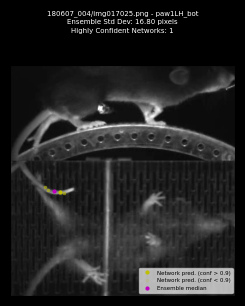

In [ ]:
def filter_csv_and_process_images(input_file, output_dir, data_dir, likelihood_threshold=4, std_threshold=2000):
    # Read the input CSV file
    df = pd.read_csv(input_file)
    
    # Filter the data based on the criteria
    filtered_df = df[
        (df['num_likelihood_above_0.9'] <= likelihood_threshold) &
        (df['ensemble_std'] <= std_threshold)
    ]
    
    # Create the output filename
    output_filename = f"frames_confidence_leq_{likelihood_threshold}_std_{std_threshold}.csv"
    output_path = os.path.join(output_dir, output_filename)
    
    # Save the filtered data to a single CSV file
    filtered_df.to_csv(output_path, index=False)
    print(f"Saved filtered data to: {output_path}")
    print(f"Total frames in filtered data: {len(filtered_df)}")

    # Parameters for image processing
    height = 3
    color = 'y'
    median_color = 'm'

    # Iterate through each row in the filtered DataFrame
    for _, row in tqdm(filtered_df.iterrows(), total=filtered_df.shape[0]):
        img_name = row['image_path']
        img_path = os.path.join(data_dir, img_name)
        
        # Check if the image file exists
        if not os.path.exists(img_path):
            print(f"Image file does not exist: {img_path}")
            continue

        # Read and process the image
        fr_ = cv2.imread(img_path)
        if fr_ is None:
            print(f"Failed to read image: {img_path}")
            continue

        fr_ = cv2.cvtColor(fr_, cv2.COLOR_BGR2RGB)
        img_height = fr_.shape[0]
        img_width = fr_.shape[1]
        h = height
        w = h * (img_width / img_height)

        fig, ax = plt.subplots(1, 1, figsize=(w, h), facecolor='k')
        
        ax.imshow(fr_, cmap='gray')

        # Plot predictions from all 5 networks
        for i in range(4):
            x = row[f'x_rng{i}']
            y = row[f'y_rng{i}']
            likelihood = row[f'likelihood_rng{i}']
            
            if likelihood > 0.9:
                ax.plot(x, y, 'o', markersize=3, color=color, alpha=1)
            else:
                ax.plot(x, y, 'o', markersize=3, color=color, alpha=0.5, markeredgecolor=color, markerfacecolor=color, markeredgewidth=0.5)

        # Plot the ensemble median
        median_x = row["ensemble_median_x"]
        median_y = row["ensemble_median_y"]
        ax.plot(median_x, median_y, 'o', markersize=3, color=median_color)

        # Prepare the title
        body_part = row["body_part"]
        ensemble_std = row["ensemble_std"]
        num_likelihood_above_0_9 = row["num_likelihood_above_0.9"]

        title = (f"{img_name.replace('labeled-data/', '')} - {body_part}\n"
                 f"Ensemble Std Dev: {ensemble_std:.2f} pixels\n"
                 f"Highly Confident Networks: {num_likelihood_above_0_9}")

        # Set the title
        ax.set_title(title, fontsize=5, color='w', y=1.1, va='bottom', linespacing=1.5)

        # Add legend
        ax.plot([], [], 'o', color=color, alpha=1, label='Network pred. (conf > 0.9)', markersize=2)
        ax.plot([], [], 'o', color=color, alpha=0.1, label='Network pred. (conf < 0.9)', markersize=2, markeredgecolor=color, markerfacecolor=color)
        ax.plot([], [], 'o', color=median_color, label='Ensemble median', markersize=2)
        ax.legend(loc='lower right', fontsize=4, framealpha=0.7)

        ax.set_xticks([])
        ax.set_yticks([])
        
        # Create the filename structure
        video_name = img_name.split('/')[1]  # Assuming the format is 'labeled-data/<video_name>/img<number>.png'
        image_number = os.path.splitext(os.path.basename(img_name))[0]
        
        # Determine the confidence level
        confidence_level = int(num_likelihood_above_0_9) if not np.isnan(num_likelihood_above_0_9) else 0

        # Get the ensemble_std_bin directly from the row
        ensemble_std_bin = row["ensemble_std_bin"]

        # Create the directory structure
        save_dir = os.path.join(output_dir, f'confidence_{confidence_level}', ensemble_std_bin)
        os.makedirs(save_dir, exist_ok=True)

        # Save the image with the new filename structure
        filename = os.path.join(save_dir, f'{video_name}_{image_number}_{body_part}.png')
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close()

    return filtered_df

# labeled_data_dir = '/teamspace/studios/this_studio/data/mirror-mouse'

# Usage
labeled_data_dir = os.path.join('data', dataset)
filtered_df = filter_csv_and_process_images(output_file_path, review_dir, labeled_data_dir, likelihood_threshold, std_threshold)